# Ethereum Replication - Data Analysis & Model Evaluation

Adapting Approach From (S. Farrugia, J. Ellul, G. Azzopardi)

#### Importing Libraries

In [1]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np
import math

# Statistical Tests
from scipy.stats import chi2_contingency, kstest

# Category Encoding
import category_encoders as ce

# Model Implementation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Model Selection
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving
import pickle

## Import & Data Cleaning

#### Set Random State

In [8]:
SEED = 65163874

#### Import Data

In [9]:
eth_df = pd.read_csv("data/1-eth/labelled_eth.csv", index_col=0).reset_index(drop=True).drop(["Address"], axis=1)
eth_df

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,...,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,1,1457.31,34.12,4815.43,3,13,0,10,3,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3976.50,834.77,9622.53,2,2,0,1,2,0.586269,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
2,1,112.90,31.87,321.42,2,3,0,3,1,0.001020,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
3,1,2300.37,65.10,73091.00,29,98,0,89,26,0.000784,...,0.0,81324.0746,5232.816018,0.0,0.0,0.0,22.0,37.0,OCoin,OCoin
4,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,0,0.00,0.00,1.52,1,1,0,1,1,4.000000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4677,0,9800.26,9384.37,489235.00,3,49,0,4,1,0.095005,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,12.0,,VIU
4678,0,0.00,0.00,173.97,1,1,0,1,1,0.700000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4679,0,7.72,502.02,1521.52,2,3,0,1,1,0.010000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0


In [10]:
eth_df['FLAG'].value_counts()

0    2502
1    2179
Name: FLAG, dtype: int64

#### Data-Cleaning

In [4]:
# Rename Long Columns
eth_df.rename({"total_transactions_(including_tnx_to_create_contract)": "total_tnxs",
             "ERC20_uniq_sent_addr.1": "ERC20_uniq_sent_addr_b"}, axis="columns", inplace=True)

In [5]:
# Drop Null Values
eth_df = eth_df.dropna()

In [6]:
# Replace Empty with Unknown
eth_df.replace(r'^\s*$', "UNKNOWN", regex=True)

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,...,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
1,1,3976.50,834.77,9622.53,2,2,0,1,2,0.586269,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,UNKNOWN,Blockwell say NOTSAFU
2,1,112.90,31.87,321.42,2,3,0,3,1,0.001020,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,UNKNOWN,Blockwell say NOTSAFU
3,1,2300.37,65.10,73091.00,29,98,0,89,26,0.000784,...,0.0,81324.0746,5232.816018,0.0,0.0,0.0,22.0,37.0,OCoin,OCoin
5,1,59129.36,0.00,118258.72,2,1,0,1,2,0.680000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,UNKNOWN,ELF
6,1,1819.90,638.12,8744.77,2,8,0,7,2,0.000000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,UNKNOWN,Blockwell say NOTSAFU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,0,0.00,0.00,1.52,1,1,0,1,1,4.000000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4677,0,9800.26,9384.37,489235.00,3,49,0,4,1,0.095005,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,12.0,UNKNOWN,VIU
4678,0,0.00,0.00,173.97,1,1,0,1,1,0.700000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4679,0,7.72,502.02,1521.52,2,3,0,1,1,0.010000,...,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0


In [7]:
# Remove Constant Columns
eth_df = eth_df.loc[:, eth_df.any(axis=0)]
eth_df

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,...,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
1,1,3976.50,834.77,9622.53,2,2,0,1,2,0.586269,...,1.337000,1.337000,1.337000,0.0,0.0000,0.000000,0.0,1.0,,Blockwell say NOTSAFU
2,1,112.90,31.87,321.42,2,3,0,3,1,0.001020,...,1.337000,1.337000,1.337000,0.0,0.0000,0.000000,0.0,1.0,,Blockwell say NOTSAFU
3,1,2300.37,65.10,73091.00,29,98,0,89,26,0.000784,...,0.000000,26436.081000,1954.484697,0.0,81324.0746,5232.816018,22.0,37.0,OCoin,OCoin
5,1,59129.36,0.00,118258.72,2,1,0,1,2,0.680000,...,14.000000,14.000000,14.000000,0.0,0.0000,0.000000,0.0,1.0,,ELF
6,1,1819.90,638.12,8744.77,2,8,0,7,2,0.000000,...,13.370000,13.370000,13.370000,0.0,0.0000,0.000000,0.0,1.0,,Blockwell say NOTSAFU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,0,0.00,0.00,1.52,1,1,0,1,1,4.000000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0,0
4677,0,9800.26,9384.37,489235.00,3,49,0,4,1,0.095005,...,0.000000,1013.165787,171.167840,0.0,0.0000,0.000000,0.0,12.0,,VIU
4678,0,0.00,0.00,173.97,1,1,0,1,1,0.700000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0,0
4679,0,7.72,502.02,1521.52,2,3,0,1,1,0.010000,...,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0,0


In [8]:
# Balance Dataset

# Get Value Counts
counts = pd.DataFrame(eth_df["FLAG"].value_counts())

# Get Maximum and Minimum
ma = counts[counts["FLAG"] == max(counts["FLAG"][0], counts["FLAG"][1])].values[0][0]
mi = counts[counts["FLAG"] == min(counts["FLAG"][0], counts["FLAG"][1])].values[0][0]

# Get Class with Most Values
ma_i = counts[counts["FLAG"] == ma].index[0]

# Remove Samples to Match Class with Least Values
eth_df = eth_df.drop(eth_df[eth_df['FLAG'] == ma_i].sample(ma - mi, random_state=SEED).index)

# Show Result
eth_df["FLAG"].value_counts()

1    1350
0    1350
Name: FLAG, dtype: int64

## Data Analysis

#### Variable Types

In [9]:
# Categorical Variables
cat = ["ERC20_most_sent_token_type", "ERC20_most_rec_token_type"]

# Numerical Variables
num = [x for x in list(eth_df.keys()) if x not in ["FLAG", "ERC20_most_sent_token_type", "ERC20_most_rec_token_type"]]

#### Number of Stats Tests (For Bonferroni Correction)

In [10]:
# Each Feature Tested for Normality and Correlation
num_tests = len(cat)        # Chi2 for Each Variable
num_tests += len(num)       # Chi2 for Each Variable

#### Define Dataframes

In [11]:
norm_df = pd.DataFrame(columns=["Feature", "Adjusted P-Value"])

In [12]:
corr_df = pd.DataFrame(columns=["Feature", "Coefficient", "Adjusted P-Value"])

#### Categorical Variables

In [13]:
# Encode String Categories to Numbers
for feat in cat:
    eth_df[feat] = pd.factorize(eth_df[feat])[0]

In [14]:
# Get Strength of Correlation
for feat in cat:

    # Re-Calculate Chi2
    cross_tab = pd.crosstab(eth_df["FLAG"], eth_df[feat])
    chi2, p, _, _ = chi2_contingency(cross_tab)

    # Calculate Cramer's V Coefficient
    n = cross_tab.sum().sum()
    cramers_v = np.sqrt(chi2 / (n*(min(cross_tab.shape)-1)))

    # Insert New Row
    corr_df.loc[len(corr_df)] = {"Feature": feat, "Coefficient": cramers_v, "Adjusted P-Value": p * num_tests}

#### Numerical Variables

In [15]:
# Check Normality

# Theoretical Normal Distribution
theoretical = np.random.randn(len(eth_df))

# Conduct KS-Tests
for feat in num:
    theoretical = np.random.randn(len(eth_df[feat]))
    st, p = kstest(eth_df[feat], theoretical)
    norm_df.loc[len(norm_df)] = {"Feature": feat, "Statistic": st, "Adjusted P-Value": p * num_tests}

In [16]:
norm_df

,Feature,Adjusted P-Value
0,Avg_min_between_sent_tnx,0.000000e+00
1,Avg_min_between_received_tnx,0.000000e+00
2,Time_Diff_between_first_and_last_(Mins),0.000000e+00
3,Sent_tnx,0.000000e+00
4,Received_Tnx,0.000000e+00
5,Number_of_Created_Contracts,1.382572e-305
6,Unique_Received_From_Addresses,0.000000e+00
7,Unique_Sent_To_Addresses,0.000000e+00
8,min_value_received,1.533917e-306
9,max_value_received,0.000000e+00


In [17]:
# Dichotomise Variables by Median
medians = eth_df[num].median()
dichotomise = lambda col: (col > medians[col.name]).astype(int)

di_num_df = eth_df[num].apply(dichotomise, axis=0)
di_num_df

,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,...,ERC20_uniq_sent_addr_b,ERC20_uniq_rec_contract_addr,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
1,1,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,1,1,1,0,1,1,0,1,...,0,1,0,1,1,0,1,1,1,1
5,1,0,1,0,0,0,0,1,1,0,...,0,0,1,1,1,0,0,0,0,0
6,1,1,0,0,1,0,1,1,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4672,1,1,1,1,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1
4674,0,1,1,0,1,1,0,0,0,1,...,0,1,1,1,1,0,0,0,0,1
4675,0,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4679,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Get Strength of Correlation
for feat in num:

    # Check Association
    cross_tab = pd.crosstab(eth_df["FLAG"], di_num_df[feat])
    chi2, p, _, _ = chi2_contingency(cross_tab)

    # Calculate Phi Coefficient
    n = cross_tab.sum().sum()
    phi = np.sqrt(chi2 / (n*(min(cross_tab.shape)-1)))

    # Insert New Row
    corr_df.loc[len(corr_df)] = {"Feature": feat, "Coefficient": phi, "Adjusted P-Value": p * num_tests}

#### Results

In [19]:
corr_df

,Feature,Coefficient,Adjusted P-Value
0,ERC20_most_sent_token_type,0.760030,4.521021e-238
1,ERC20_most_rec_token_type,0.941410,0.000000e+00
2,Avg_min_between_sent_tnx,0.209630,4.496983e-26
3,Avg_min_between_received_tnx,0.000000,3.600000e+01
4,Time_Diff_between_first_and_last_(Mins),0.051111,2.848244e-01
5,Sent_tnx,0.257805,2.299817e-39
6,Received_Tnx,0.049669,3.547586e-01
7,Number_of_Created_Contracts,0.280768,1.185570e-46
8,Unique_Received_From_Addresses,0.235715,6.191135e-33
9,Unique_Sent_To_Addresses,0.260103,4.570119e-40


In [20]:
def plot_coeffs(title, data):
    # Create Plot
    ax = sns.barplot(x='Feature', y='Coefficient', data=data, palette=data['Color'])

    # Set Labels
    ax.set_title(title)
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Coefficient")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', marker='s', linestyle='', markersize=10, label='Significant'),
        plt.Line2D([0], [0], color='red', marker='s', linestyle='', markersize=10, label='Not Significant')
    ]

    plt.legend(handles=legend_elements)

    # Save Image
    plt.savefig("figures/eth/" + title + ".pdf", format="pdf", bbox_inches="tight")

    # Show Image
    plt.show()

In [21]:
# Prep For Plot

# Get Column Color
corr_df['Significant'] = [True if x < 0.05 else False for x in corr_df['Adjusted P-Value']]
corr_df['Color'] = corr_df['Significant'].map({True: "green", False: "red"})

# Sort Ascending Coefficient
corr_df = corr_df.sort_values('Coefficient')

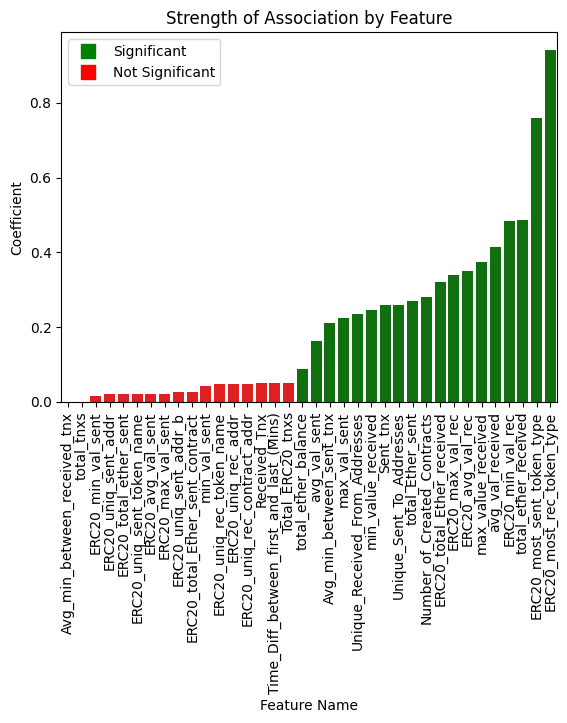

In [22]:
# All Features
plot_coeffs("Strength of Association by Feature", corr_df)

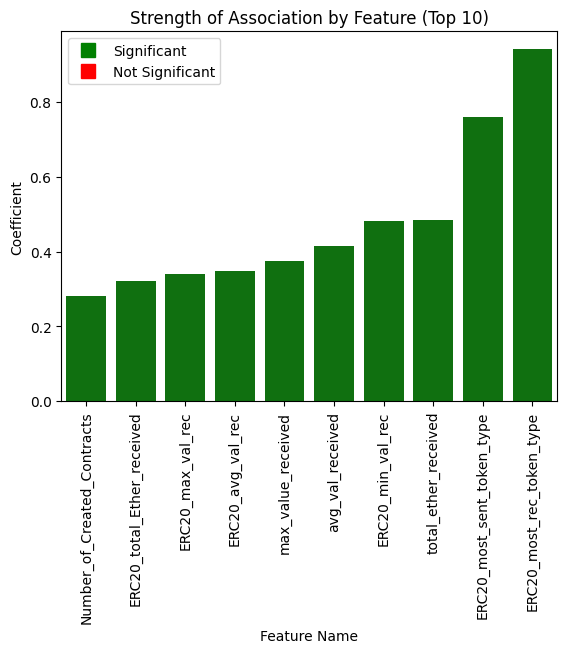

In [23]:
# Top 10
plot_coeffs("Strength of Association by Feature (Top 10)", corr_df.tail(10))

## Model Implementation

#### Pre-Processing

In [24]:
# Split Target/Features
x = eth_df.drop(["FLAG"], axis=1)
y = eth_df["FLAG"]

In [25]:
# Get Features List
chosen = list(corr_df.loc[(corr_df["Coefficient"] >= 0.15) & (corr_df["Adjusted P-Value"] < 0.05)]["Feature"])
x = x[chosen]

In [26]:
# Category Encoding
encoder = ce.BinaryEncoder(cols=["ERC20_most_sent_token_type", "ERC20_most_rec_token_type"])

x = encoder.fit_transform(x)

In [27]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=SEED)

#### Hyperparameter Optimisation

In [28]:
# Define Parameter Grid
rf_grid = {
    "n_estimators": [1, 25, 50, 75, 100],
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [1, 10, 100, 1000, None],
    "min_samples_split": [2, 10, 20, 30, 40],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
    "random_state":[SEED]
}

In [29]:
# Perform Cross Validation
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rf_cv = GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=rf_grid,
                     cv=splitter,
                     n_jobs=-1,
                     scoring='accuracy',
                     refit=True)

# Grid Search
rf_cv.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=65163874, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 10, 100, 1000, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 10, 20, 30, 40],
                         'n_estimators': [1, 25, 50, 75, 100],
                         'random_state': [65163874]},
             scoring='accuracy')

In [30]:
# Show Best Model Parameters
rf_cv.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100,
 'random_state': 65163874}

## Model Evaluation

#### Get Best Model

In [31]:
# Get Best Model
rf = rf_cv.best_estimator_

#### Make Predictions

In [32]:
# Make Predictions
y_pred = rf.predict(x_test)

#### Metrics

In [33]:
# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# 95% Confidence Interval
ci = 1.96 * math.sqrt((acc * (1 - acc)) / len(y_test))
print("CI: %.3f" % ci)

F1 Score:  0.9822485207100592
Accuracy:  0.9822222222222222
CI: 0.010


#### Confusion Matrix

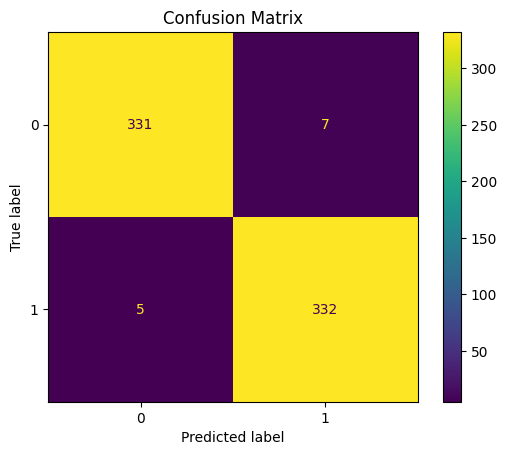

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.savefig("figures/eth/" + "Confusion Matrix" + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Save Model

In [35]:
pickle.dump(rf, open('models/rf_eth.pickle', 'wb'))